# CS830 - Machine Learning for Data Analytics - Coursework 2

## Introduction

### Selected Problem

This report focuses on predicting the burnt area of forest fires using a dataset from the Montesinho natural park in Portugal. The dataset includes 517 records of forest fires, capturing temporal variables (weekday and month), spatial coordinates, and meteorological data (rain, temperature, humidity, and wind). The target variable is the burnt area of the forest, measured in hectares.

### Objective

The primary objective of this project is to develop a Deep Learning model using Keras that accurately predicts the burnt area of forest fires based on the given temporal, spatial, and meteorological variables. By leveraging the power of Artificial Neural Networks (ANNs), the model aims to learn complex patterns and relationships within the data, providing reliable predictions that can inform effective forest fire management strategies.

### Importance

Forest fires pose significant threats to the environment, wildlife, and human settlements. Predicting the extent of forest fires can aid in better resource allocation, timely evacuation, and implementation of preventive measures. This project aligns with the broader goal of minimizing the impact of natural disasters through advanced machine learning techniques.


### Packages Used

Python Version: 3.12.2

Software: Visual Studio Code, Jupyter Notebook

The main libraries are listed below (Seperate section for Keras later in report):

In [797]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import warnings
import geopandas as gpd
import folium
import seaborn as sns
import numpy as np
from PIL import Image
import io
from typing import Tuple, List, Dict

In [875]:
# Disabling console warnings
warnings.filterwarnings('ignore')

# Importing the dataset
raw_df = pd.read_csv('forestfires.csv')

### Summary of Dataset

The dataset uses [Forset Fire Area](https://www.kaggle.com/datasets/sumitm004/forest-fire-area) which contains 517 fires from the Montesinho Natural Park in Portugal. (Mishra, 2024) As shown below the data is a mixture of integers, strings and float objects.

In [876]:
print(raw_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB
None


In [877]:
print(f"The dataset has a shape of: {raw_df.shape}.")

# Min and Max values for the X and Y columns
x_min, x_max = raw_df['X'].min(), raw_df['X'].max()
y_min, y_max = raw_df['Y'].min(), raw_df['Y'].max()

print(f"X column range: min = {x_min}, max = {x_max}")
print(f"Y column range: min = {y_min}, max = {y_max}")


The dataset has a shape of: (517, 13).
X column range: min = 1, max = 9
Y column range: min = 2, max = 9


The dataset has the below variables:
-   **X**: X-axis spatial coordinate within the Montesinho park map (integer).
-   **Y**: Y-axis spatial coordinate within the Montesinho park map (integer).
-   **month**: Month of the year when the fire was recorded (string, e.g., "jan", "feb").
-   **day**: Day of the week when the fire was recorded (string, e.g., "mon", "tue").
-   **FFMC**: Fine Fuel Moisture Code, indicating the moisture content of litter and other cured fine fuels (float).
-   **DMC**: Duff Moisture Code, representing the average moisture content of loosely compacted organic layers of moderate depth (float).
-   **DC**: Drought Code, which measures the moisture content of deep, compact organic layers (float).
-   **ISI**: Initial Spread Index, which estimates the rate of fire spread (float).
-   **temp**: Temperature in degrees Celsius (float).
-   **RH**: Relative humidity as a percentage (integer).
-   **wind**: Wind speed in kilometers per hour (float).
-   **rain**: Amount of rainfall in millimeters (float).
-   **area**: The burned area of the forest (in hectares, float).

## Exploratory Data Analysis (EDA)

### Montesinho Natural Park

The map below outlines Montesinho Natural Park, situated in the northeast of Portugal. The geographic data provided by (UNEP-WCMC and IUCN, 2024) is sourced from "protectedplanet.net."

Montesinho Natural Park spans approximately 742.25 km² and is home to around 9,000 inhabitants across 92 villages. The park experiences temperatures ranging from -12ºC to 40ºC, with an average elevation between 750 and 900 meters, and a maximum elevation of 1,486 meters. (A. Montesinho, 2024)

In [878]:
# Load the shapefile
gdf = gpd.read_file('montesinho_park.shp')

# Ensure the CRS is set
if gdf.crs is None:
    gdf.set_crs(epsg=4326, inplace=True)

m = folium.Map(location=[gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()], zoom_start=10)

# Function to style the polygon
def style_function(feature):
    return {
        'fillOpacity': 0.5,
        'weight': 1,
        'color': 'black'
    }

# Add the polygon to the map with a popup showing "Montesinho Park"
for idx, row in gdf.iterrows():
    folium.GeoJson(
        row['geometry'],
        name='Montesinho Park',
        style_function=style_function,
        highlight_function=lambda x: {'weight': 3, 'color': 'blue'},
        popup=folium.Popup("Montesinho Park", parse_html=True)
    ).add_to(m)
folium.LayerControl().add_to(m)

m

Previous studies utilising the same dataset, such as (Nguyen & Chakraborty, 2016), have referenced a grid system for spatial analysis. To enhance our understanding of the geographic distribution, the grid system has been approximated and overlaid onto the map. This visualisation allows for a more comprehensive spatial analysis of the phenomena under investigation.

In [879]:
# Define the coordinates and grid dimensions
miny, minx = -7.22, 41.70
grid_height = 0.035
grid_width = 0.08
num_rows, num_cols = 9, 9

# Calculate the max coordinates based on grid dimensions
maxx = minx + num_cols * grid_height
maxy = miny + num_rows * grid_width


# Add the grid to the map
for i in range(num_rows + 1):
    # Horizontal lines
    y = miny + i * grid_width
    folium.PolyLine([(minx, y), (maxx, y)], color='red', weight=1).add_to(m)
    
    # Add numbers to the left axis
    if i < num_rows:  
        folium.Marker(
            [minx - 0.02, y + grid_width/2],
            icon=folium.DivIcon(html=f'<div style="font-size: 10pt">{i + 1}</div>')
        ).add_to(m)

for j in range(num_cols + 1):
    # Vertical lines
    x = minx + j * grid_height
    folium.PolyLine([(x, miny), (x, maxy)], color='red', weight=1).add_to(m)
    
    # Add numbers to the top axis
    if j < num_cols: 
        folium.Marker(
            [x + grid_height/2, miny - 0.02],  
            icon=folium.DivIcon(html=f'<div style="font-size: 10pt">{num_cols - j}</div>')
        ).add_to(m)

# Add layer control to toggle the visibility of layers
folium.LayerControl().add_to(m)

# Display the map
m

In [880]:
# Save the image - selenium must be installed to allow a screenshot
img_data = m._to_png(5)
map_img = Image.open(io.BytesIO(img_data))

# Open the PNG image data with Pillow
map_img = Image.open(io.BytesIO(img_data))

# Crop the image - this will be used later on in the report
zoomed_map_img = map_img.crop((350, 200, 950, 600))

### Diagrams

Several histograms have been produced below to visualise the data.

1.  **Distribution of FFMC (Fine Fuel Moisture Code)**: The distribution is heavily skewed to the left, with a sharp peak near the maximum value (around 90-95). This suggests that the fine fuels in the forest are frequently very dry, which could indicate high fire risk conditions are common in the dataset.
2.  **Distribution of DMC (Duff Moisture Code)**: This shows a bimodal distribution with peaks around 50 and 125. The bimodality might indicate two distinct moisture conditions in the duff layer, possibly corresponding to different seasons or weather patterns.
3.  **Distribution of DC (Drought Code)**: The distribution appears trimodal, with peaks around 100, 400, and 700. This could represent different drought conditions throughout the year, possibly corresponding to wet, normal, and dry seasons.
4.  **Distribution of ISI (Initial Spread Index)**: Highly right-skewed with a peak near 0-5 and a long tail extending to higher values. This suggests that while low spread potential is common, there are occasional instances of very high spread risk.
5.  **Distribution of temp (Temperature)**: Approximately normal distribution with a slight right skew, centered around 20-25°C. This reflects expected temperature variations, with some hotter outliers.
6.  **Distribution of RH (Relative Humidity)**: Slightly left-skewed with a peak around 40-50%. This distribution suggests that moderate humidity levels are most common, with fewer instances of very high humidity.
7.  **Distribution of wind**: Right-skewed distribution with a peak around 2-4 km/h. The long right tail indicates occasional high wind speeds, which could significantly increase fire spread risk.

Overall, these distributions provide insights into the environmental conditions relevant to forest fire risk. The skewed nature of many variables (especially FFMC and ISI) suggests that extreme conditions, which might be associated with higher fire risk, are not uncommon in this dataset. The multimodal distributions of DMC and DC could indicate seasonal patterns that might be important for fire prediction models.

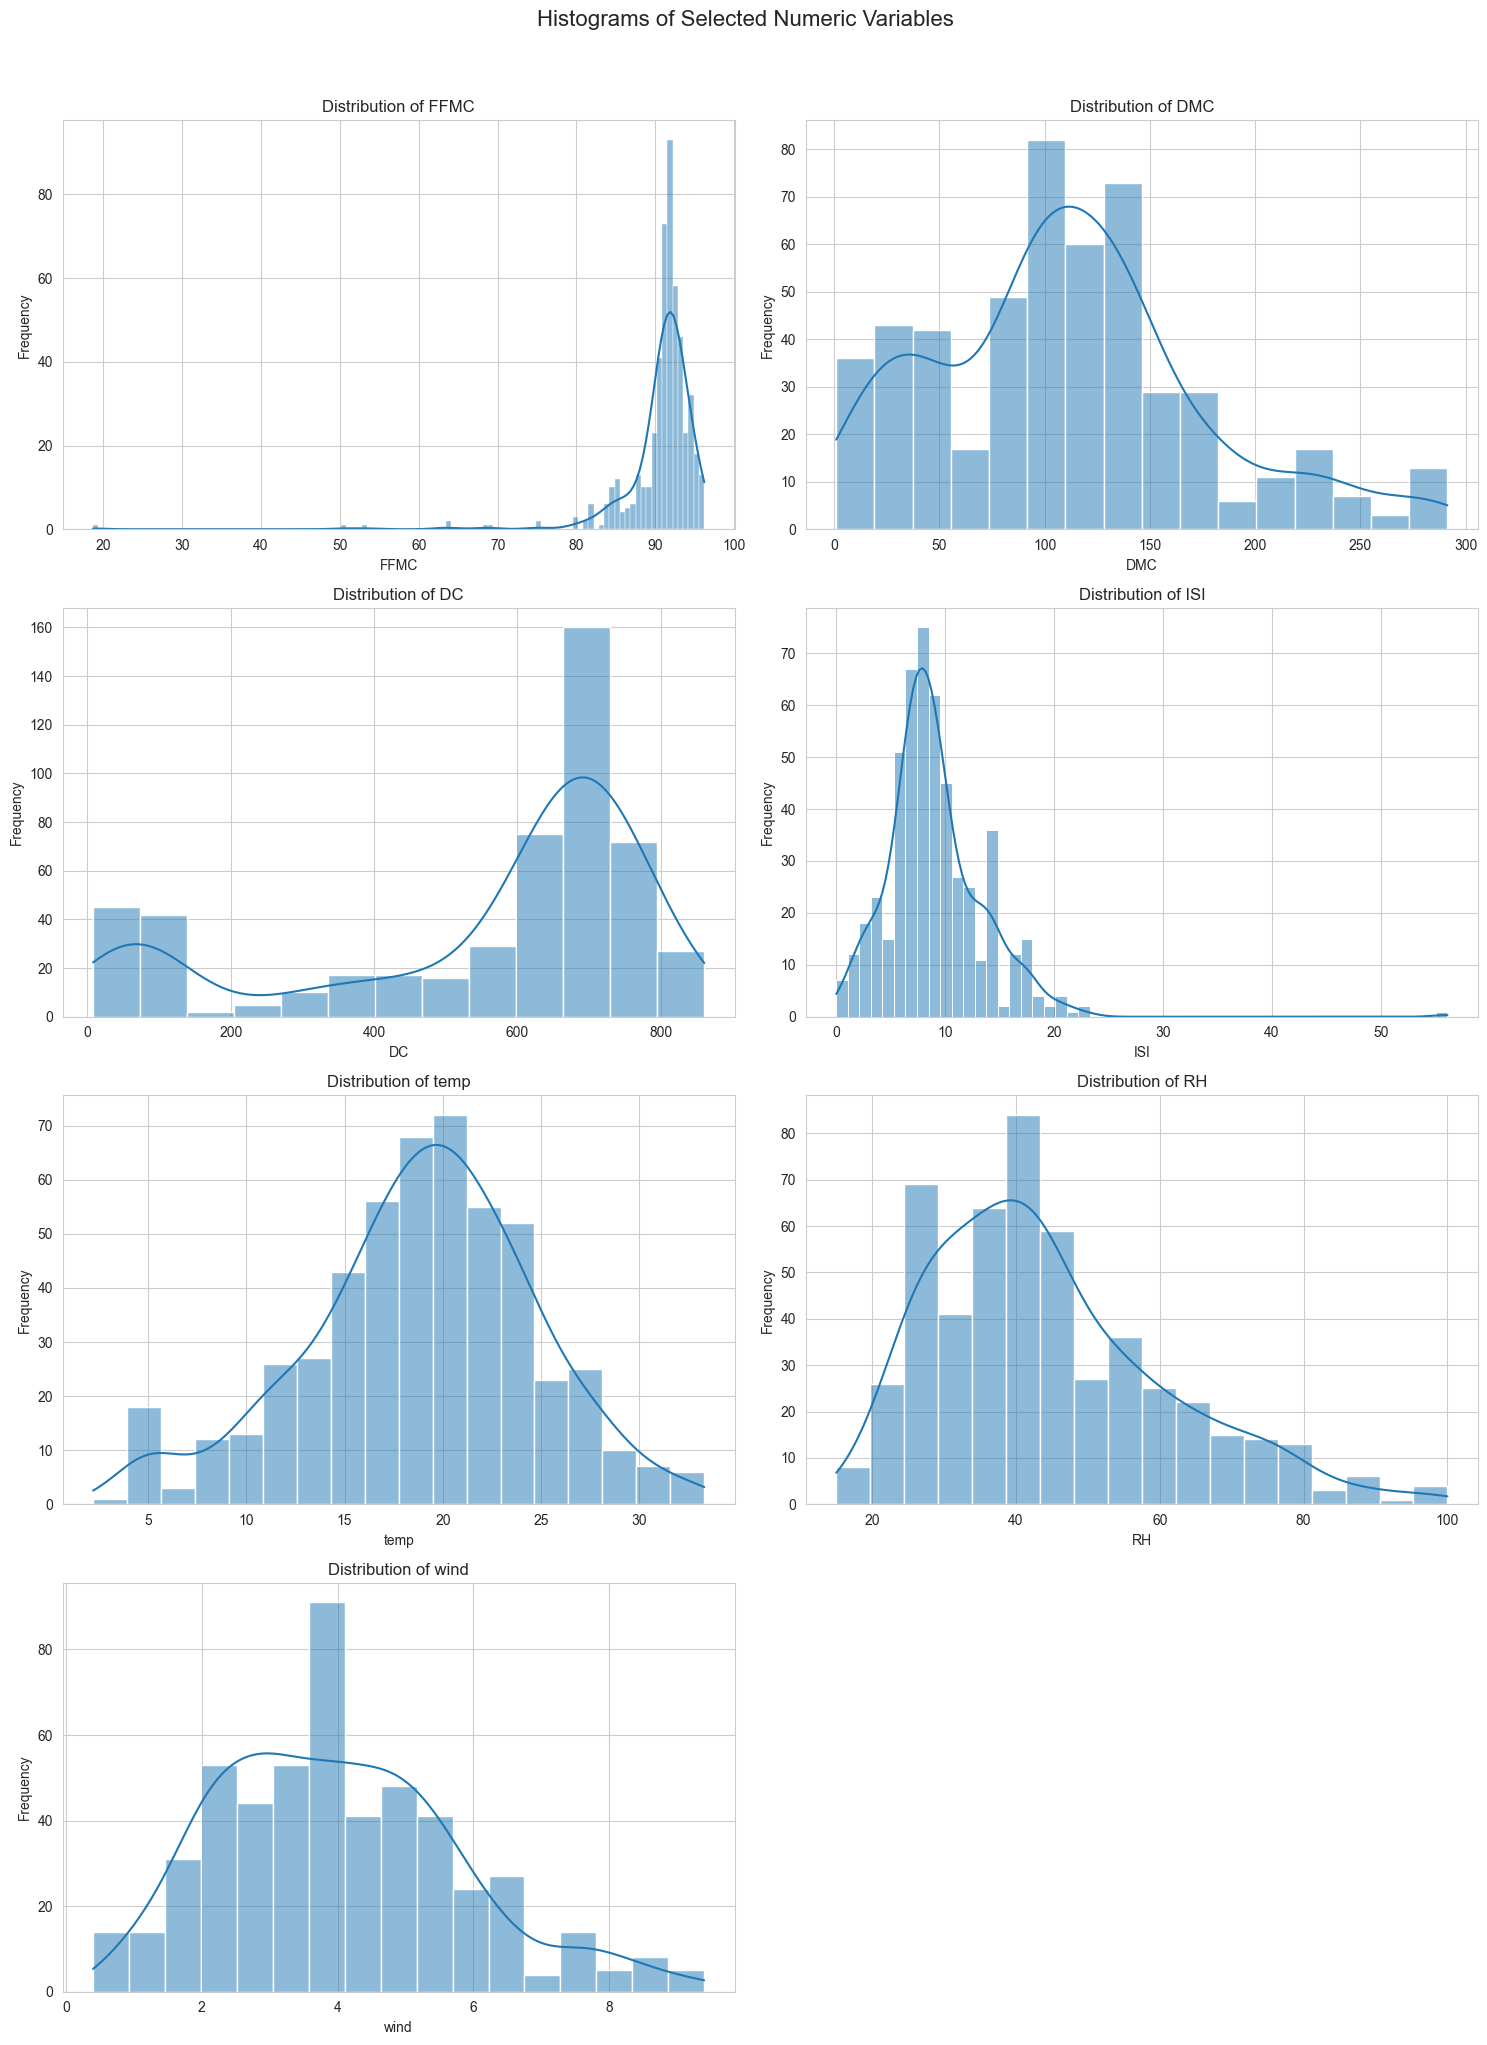

In [881]:
# Select numeric columns, excluding 'X', 'Y', 'area', and 'rain'
columns_to_plot = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind']
histogram_df = raw_df[columns_to_plot]

# Calculate the number of rows needed
n_rows = (len(columns_to_plot) + 1) // 2

# Create histograms for selected numeric variables
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(15, 5 * n_rows))
fig.suptitle('Histograms of Selected Numeric Variables', fontsize=16, y=1.02)

for i, column in enumerate(columns_to_plot):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    sns.histplot(data=histogram_df, x=column, kde=True, ax=ax)
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

# Remove any empty subplots
for i in range(len(columns_to_plot), n_rows * 2):
    fig.delaxes(axes.flat[i])

plt.tight_layout()
plt.show()

-   **Fires by Month:** Peak fire season occurs in August and September. There is a clear seasonal pattern, with summer months (June, July, August) showing the highest number of fires. March exhibits a moderate number of fires, suggesting a possible secondary spring fire season. The winter months (December, January, February) have the fewest fires. There is a sharp decline in fire frequency from September to October.

-   **Temperature vs Area Burned:** Most fires burn small areas, regardless of temperature. There is a slight trend of larger potential fire size with higher temperatures. The largest fires occurred between 20°C and 30°C. There are a few outliers with very large burned areas observed around 25°C and 28°C. Fires occur across a wide temperature range (2°C to 33°C), with a higher frequency at higher temperatures.

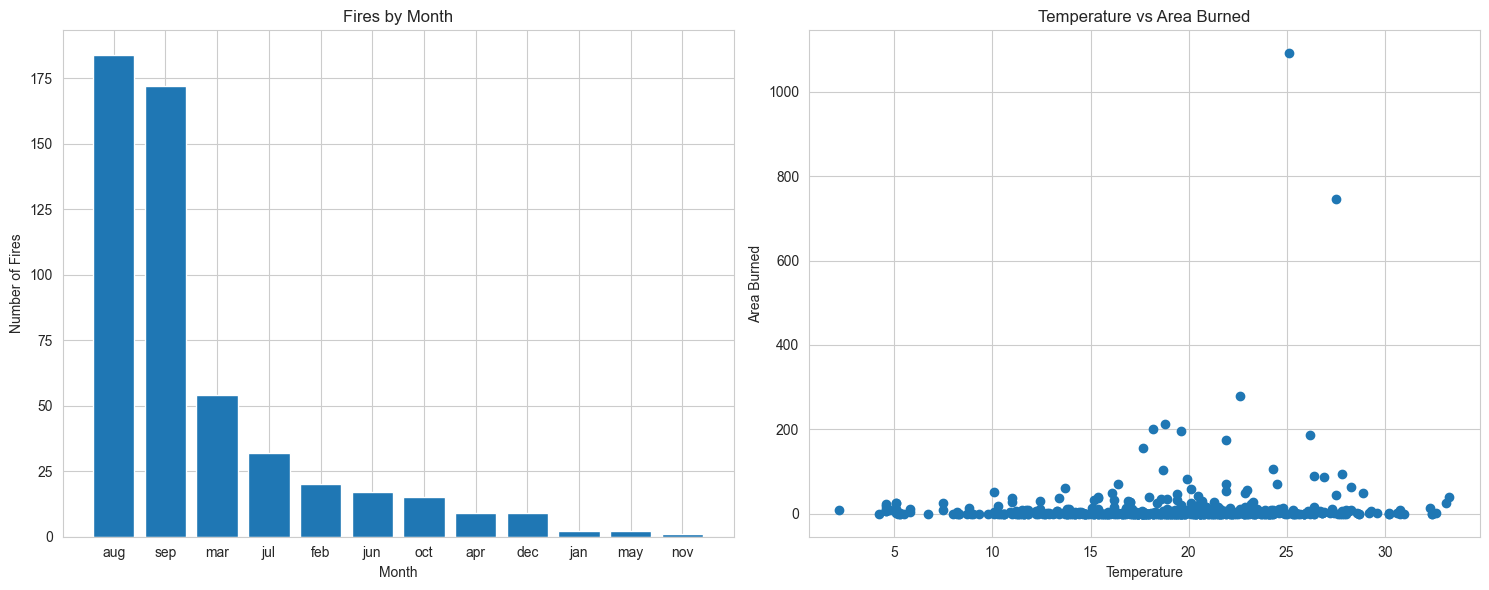

In [882]:
# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart of fire by month
axs[0].bar(raw_df['month'].value_counts().index, raw_df['month'].value_counts())
axs[0].set_title('Fires by Month')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Number of Fires')

# Scatter plot of temp vs area burned
axs[1].scatter(raw_df['temp'], raw_df['area'])
axs[1].set_title('Temperature vs Area Burned')
axs[1].set_xlabel('Temperature')
axs[1].set_ylabel('Area Burned')

plt.tight_layout()
plt.show()

The forest fire data has been geographically visualised using two complementary representations: a geographical map with a 9x9 grid overlay and a corresponding heat map grid. The heat map grid quantifies fire activity across the 81 cells, using a color scale from white (low) to dark red (high), with values ranging from 0 to 52 fires per cell.

From the images there appears to be a distinct pattern of fire distribution. The highest fire activity was concentrated in the central and eastern parts of the grid, particularly in cells (8, 4), (6, 5), and (3, 6), with the maximum recorded value of 52 fires in cell (8, 4). There's a notable concentration of fire events in the middle rows (4-7) of the grid, while the top and bottom rows show minimal activity. This uneven distribution of fire occurrences across the region suggests localized areas of high fire risk.

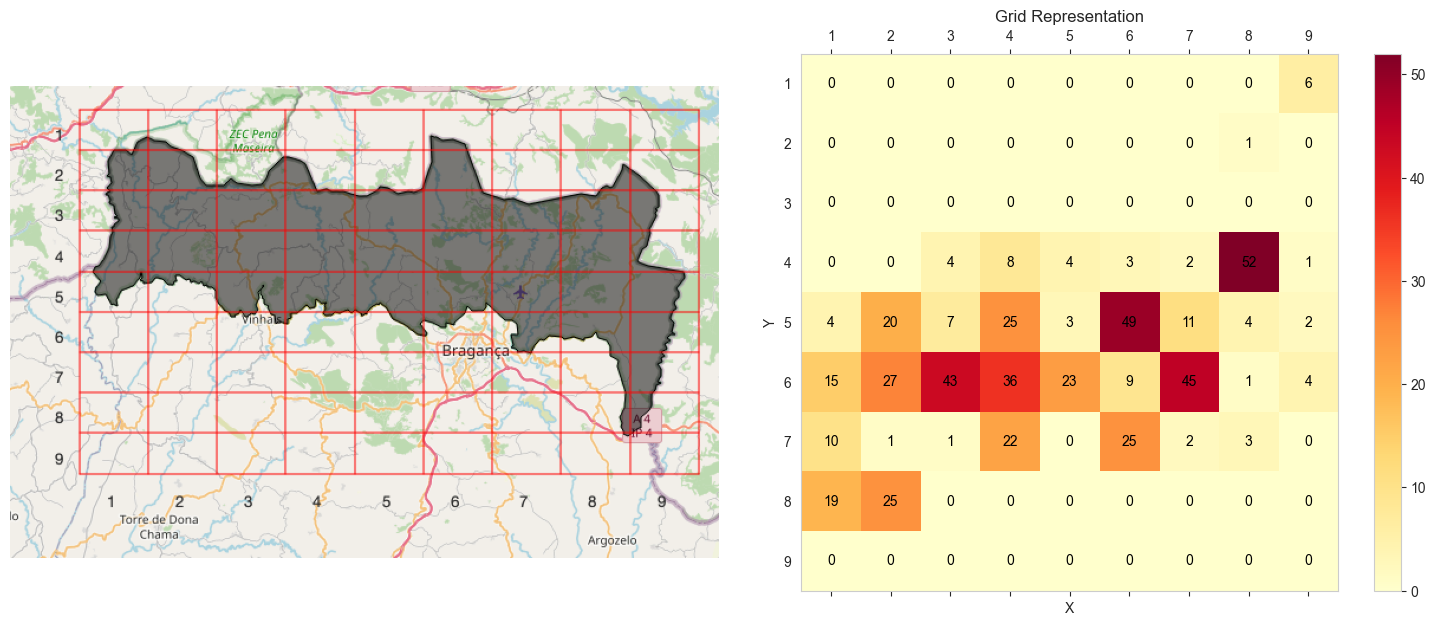

In [883]:
# Calculate number of fires by each grid square (X, Y)
fires_per_grid = raw_df.groupby(['X', 'Y']).size().reset_index(name='count')

# Create a 9x9 grid matrix to visualize
grid_matrix = np.zeros((9, 9), dtype=int)

for index, row in fires_per_grid.iterrows():
    x = row['X'] - 1  # Adjusting to start from 0 index
    y = 8 - (row['Y'] - 1)  
    grid_matrix[y, x] = row['count']

# Create the figure with two subplots: bar chart and grid
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Display the Folium map in the first subplot
ax1.imshow(zoomed_map_img)
ax1.axis('off')

# Grid plot
cax = ax2.matshow(grid_matrix, cmap='YlOrRd')
ax2.set_title('Grid Representation')
ax2.set_xticks(np.arange(9))
ax2.set_yticks(np.arange(9))  # Reverse the Y-axis ticks
ax2.set_xticklabels(np.arange(1, 10))
ax2.set_yticklabels(np.arange(1, 10))  # Keep Y-axis labels from 1 to 9
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.grid(False)

# Add text annotations for each grid square
for i in range(9):
    for j in range(9):
        ax2.text(j, i, grid_matrix[i, j], ha='center', va='center', color='black')

# Add color bar for grid plot
fig.colorbar(cax, ax=ax2)

plt.tight_layout()
plt.show()

Several boxplots below have been produced for variables in the dataset:
-   FFMC, DMC, DC, ISI: FFMC shows a narrow distribution with some outliers. DMC and DC have wider ranges, with DC showing extreme variability. ISI has a moderate range with several high outliers.
-   Temperature (temp): Mostly clustered between 15-25°C, with some outliers at lower temperatures.
-   RH (Relative Humidity): Wide distribution, ranging roughly from 20% to 80%, with outliers at both extremes.-   Wind: Mostly concentrated below 6 km/h, with several high outliers.
-   Rain: Predominantly near zero, with a few significant outliers, indicating mostly dry conditions with occasional rainfall events.
-   Area (burnt area): Extremely right-skewed distribution. Most fires are small, but there are numerous outliers representing much larger burnt areas. This skewness suggests a transformation could be beneficial.

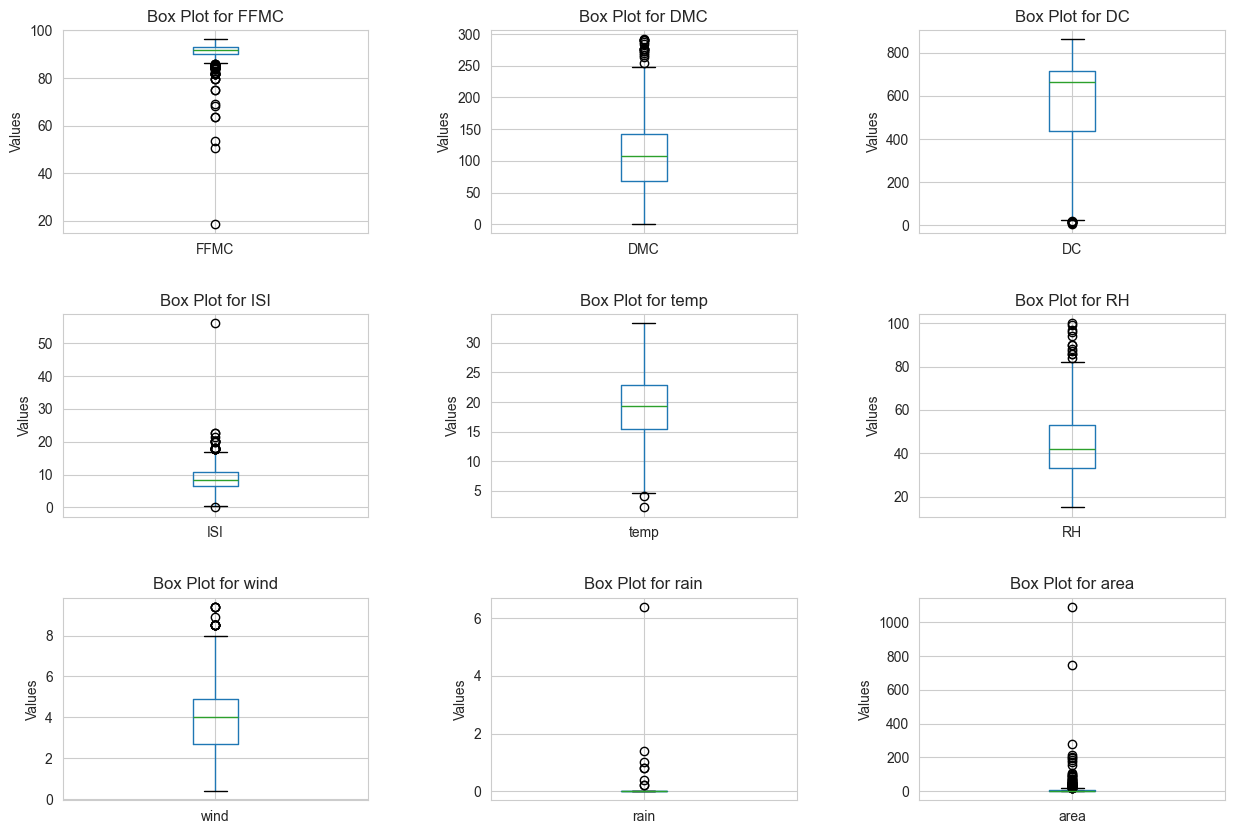

In [884]:
# List of columns to plot
columns = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area']

# Number of plots
num_plots = len(columns)
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Flatten the axis array for easy iteration
axs = axs.flatten()

# Create individual box plots for each column
for i, column in enumerate(columns):
    raw_df.boxplot(column=column, ax=axs[i])
    axs[i].set_title(f'Box Plot for {column}')
    axs[i].set_ylabel('Values')

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.show()

The correlation heatmap reveals complex relationships among the variables in the forest fire dataset. Strong positive correlations was observed between DMC and DC (0.68), and FFMC and ISI (0.53), indicating interrelated fire risk factors. Temperature shows moderate positive correlations with FFMC, DMC, and DC, while having a strong negative correlation with relative humidity (-0.53), as expected. 

Notably, the X and Y coordinates demonstrate a moderate correlation (0.54), suggesting geographical patterns in fire occurrences. Wind speed and rainfall exhibit weak correlations with most variables. Surprisingly, the area burned shows very weak correlations across all variables, with the strongest being temperature (0.10). This suggests that fire size prediction may be complex, potentially requiring sophisticated modeling techniques to capture the intricate interactions between multiple factors.

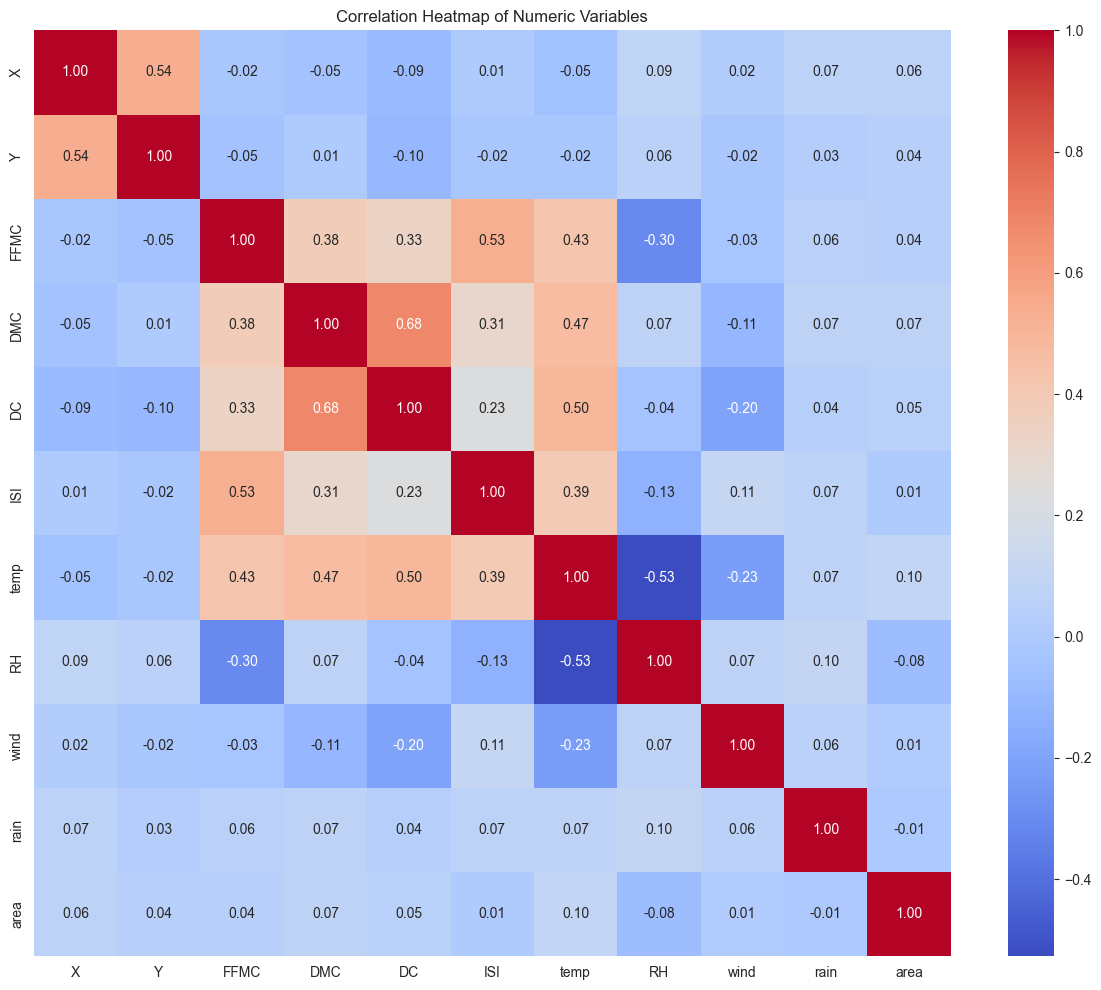

In [885]:
# Select only numeric columns for correlation matrix
numeric_df = raw_df.select_dtypes(include=['int64', 'float64'])

# Create correlation matrix and heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numeric Variables')
plt.tight_layout()
plt.show()

## Pre-Processing & Feature Engineering

The chapter focusing on getting the data set up to be used in the machine learning model. This includes basic tasks such as checking for missing values, converting categorical values into numerical representations and the normalising/ standardising the numerical features. The part will also split the dataset into features (X) and target variable (area).

This part of the report focusing on the consideration of selecting relevant features that have a strong correlation with the target variables. It will also look into the creation of new features by combining existing features or by applying mathematical transformation if necessary.

First there was a check on any missing values from the dataset.

In [886]:
# Check for missing values
print("Missing values:")
print(raw_df.isnull().sum())

Missing values:
X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64


Next, the `month` and `day` values were transformed from strings to integers using the sklearn Label Encoder.

In [887]:
from sklearn.preprocessing import LabelEncoder

# Convert categorical variables to numerical representations
label_encoder = LabelEncoder()
raw_df['month'] = label_encoder.fit_transform(raw_df['month'])
raw_df['day'] = label_encoder.fit_transform(raw_df['day'])

Rather than having 2 variables representing the date, the decision was made to convert it into a single value called `day_of_year`, which would be the specific day in the year as an integer. This approach emphasises the point in the year when the fire occurred, which is likely more relevant for analysis, than the specific day of the month. By converting dates into a continuous numerical format, the model could better capture seasonal patterns and temporal trends, potentially leading to improved performance in predicting fire behavior.

In [888]:
# Take a reference year (the data was collected in 2007 so we will use that)
reference_year = 2007

# Adjust for zero-indexed months and days
raw_df['month'] = raw_df['month'] + 1
raw_df['day'] = raw_df['day'] + 1

# Convert month and day to date
raw_df['date'] = pd.to_datetime(raw_df['month'].astype(str) + '-' + (raw_df['day']+1).astype(str) + '-' + str(reference_year), format='%m-%d-%Y', errors='coerce')

# Handle potential errors if date creation fails
if raw_df['date'].isnull().any():
    raise ValueError("Some dates are invalid. Please check the 'month' and 'day' columns.")

# Extract the day of the year and drop columns
raw_df['day_of_year'] = raw_df['date'].dt.dayofyear
raw_df.drop(['month', 'day', 'date'], axis=1, inplace=True)

The next aspect examined was the X and Y coordinates. The dataset was relatively small, containing only 81 different squares where fires could occur.

From the exploratory data analysis, a subtle pattern emerged, with fires tending to concentrate in the center and center-left of the area. Clustering was considered as a method to group this data into a certain number of clusters. However, this approach was ultimately deemed suboptimal. Clustering is typically used when seeking to discover inherent groupings or patterns based on feature similarities, but the data points already have a natural grouping based on their (x,y) coordinates. Using Euclidean distance from a hotspot was also explored, but this idea was discarded due to the spread of fires and the lack of a clear, dominant hotspot.

Given these considerations, it was decided to convert the x and y values into a single unique identifier, as there were only 81 different grid cells. The following formula was used to store the location data in a singular identifier column: 

`raw_df['location_identifier'] = raw_df['Y'] * (max_x + 1) + raw_df['X']`

 This formula creates a unique identifier for each (X, Y) pair in the grid. The approach preserves some information about the relative position of the points, avoids identifier collisions, and maintains a level of spatial coherence. While it doesn't capture exact distances or spatial relationships, it can be useful for analyses that benefit from preserving relative spatial information, aligning well with the goal of predicting burnt areas using a deep learning model.

In [889]:
max_x = raw_df['X'].max()  # Find the maximum value of x in the dataset

raw_df['location_identifier'] = raw_df['Y'] * (max_x + 1) + raw_df['X']  # Calculate the unique identifier

raw_df.drop(['X', 'Y'], axis=1, inplace=True)

The decision was made to forego dimensionality reduction for this dataset. With 12 features (excluding the target variable 'area'), the dataset is not considered highly dimensional, making dimensionality reduction unnecessary.

The original boxplot of the 'area' variable revealed the presence of outliers and a skewed distribution. To address this issue, the dataset was filtered to exclude forest fires with an area below 0.1 and above 300. This filtering step helped to remove extreme outliers that could potentially distort the analysis.

Furthermore, a logarithmic transformation was applied to the filtered `area` variable, creating a new `log_area` feature. The log transformation is commonly used to handle skewed distributions and reduce the impact of extreme values. By applying the log transformation, the distribution of the 'area' variable becomes more symmetrical and closer to a normal distribution, as evident from the boxplot of the log-transformed area.

The side-by-side comparison of the original and log-transformed boxplots clearly illustrates the improvement in the distribution after applying the log transformation. The log-transformed boxplot exhibits a more balanced and compact distribution, without the presence of extreme outliers. By filtering the dataset and applying the log transformation, the analysis becomes more robust and less sensitive to outliers.

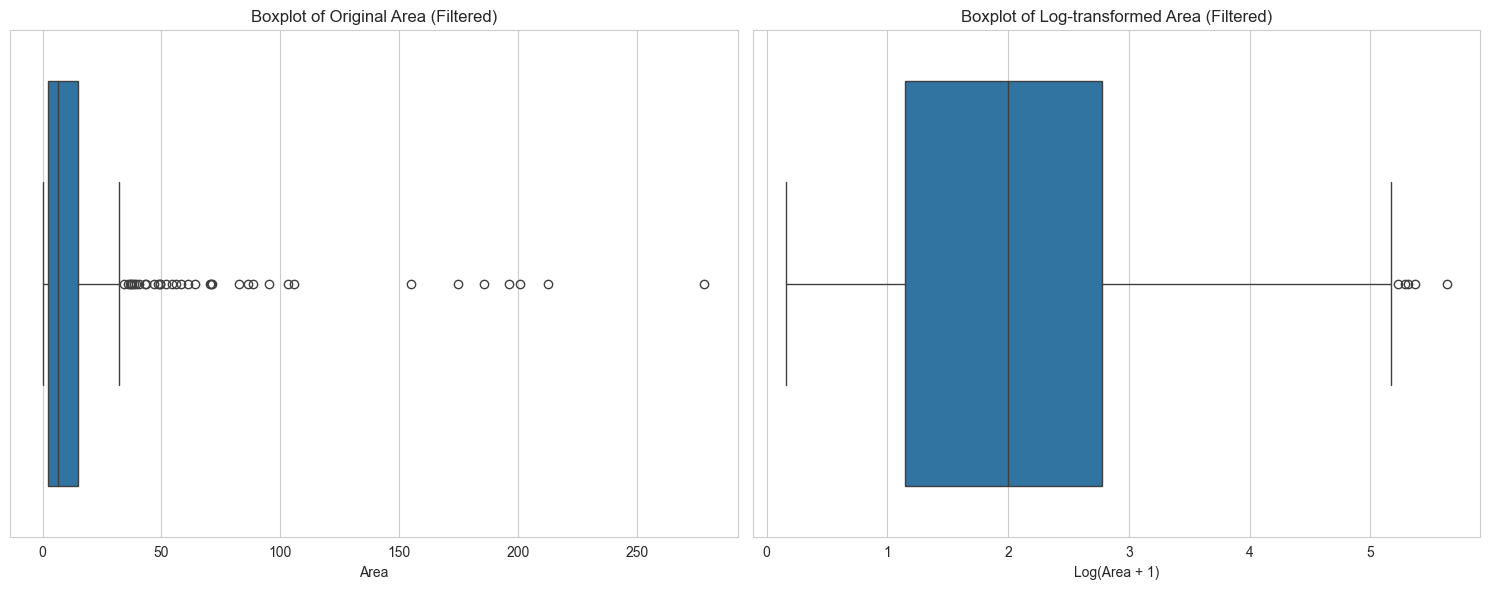

In [890]:
# Remove forest fires with area above 300 and below 0.1
raw_df = raw_df[raw_df['area'] >= 0.1].copy()
raw_df = raw_df[raw_df['area'] <= 300].copy()

# Apply log transformation to the filtered dataset
raw_df['log_area'] = np.log1p(raw_df['area'])

# Create boxplots to compare distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Original area boxplot (filtered)
sns.boxplot(x=raw_df['area'], ax=ax1)
ax1.set_title('Boxplot of Original Area (Filtered)')
ax1.set_xlabel('Area')

# Log-transformed area boxplot
sns.boxplot(x=raw_df['log_area'], ax=ax2)
ax2.set_title('Boxplot of Log-transformed Area (Filtered)')
ax2.set_xlabel('Log(Area + 1)')

plt.tight_layout()
plt.show()

In [891]:
# Drop the Area
raw_df = raw_df.drop(['area'], axis=1)

The correlation matrix revealed a multicollinearity problem among the features FFMC, DMC, DC, and ISI. Multicollinearity occurs when there is a high correlation between independent variables, which can lead to unstable and unreliable coefficients in regression models.

To identify the specific feature pairs with high correlation, a threshold of 0.7 was set. The code iterates through the correlation matrix and finds feature pairs with an absolute correlation value above the threshold. The resulting output showed a high correlation between ISI and FFMC, with a correlation coefficient of 0.70.

To address the multicollinearity issue, the decision was made to remove the FFMC feature from the dataset using the `drop` function. By eliminating one of the highly correlated features, the multicollinearity problem is mitigated, as the remaining features are less correlated with each other.

Removing highly correlated features is beneficial because it simplifies the model and improves its interpretability. When multicollinearity is present, the coefficients of the correlated features can be unstable and difficult to interpret. By removing one of the correlated features, the model becomes more stable, and the coefficients of the remaining features can be interpreted more reliably.

In [892]:
correlation_matrix = raw_df.corr()

# Find highly correlated feature pairs
corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:  # Threshold
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            corr_pairs.append((colname_i, colname_j, correlation_matrix.iloc[i, j]))

# Print correlated pairs
for pair in corr_pairs:
    print(f"High correlation between {pair[0]} and {pair[1]}: {pair[2]:.2f}")



High correlation between ISI and FFMC: 0.70


In [893]:
df_selected = raw_df.drop(['FFMC'], axis=1)

## Polynomial Features

To further enhance the predictive model, interaction features were created using the `PolynomialFeatures` class from scikit-learn. By setting `degree=2` and `interaction_only=True`, pairwise interaction terms were generated between the original features. These interaction features captured the combined effect of multiple variables on the target variable, allowing the model to uncover non-linear relationships and dependencies that individual features alone might not have captured.

Additionally, feature selection was performed based on the correlation between each feature and the target variable. Features with an absolute correlation greater than 0.2 were selected using the `corrwith` function. This step aimed to identify the most relevant features for predicting the target variable, potentially improving model performance and reducing overfitting. By focusing on features with higher correlation, the model could prioritise the most informative variables while simplifying its structure and enhancing interpretability.

In [895]:
from sklearn.preprocessing import PolynomialFeatures

# Separate features and target
X = df_selected.drop(['log_area'], axis=1)
y = df_selected['log_area']

# Create interaction features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interactions = poly.fit_transform(X)

# Convert X_interactions to a DataFrame
X_interactions_df = pd.DataFrame(X_interactions, columns=poly.get_feature_names_out(X.columns))

# Select features based on correlation
correlations = X_interactions_df.corrwith(y)
selected_features = correlations[abs(correlations) > 0.2].index

X_selected = X_interactions_df[selected_features]

## Scaling and Splitting Dataset

This chapter focusing on scaling the dataset. 

Going forward we have now the following variables to use:

-   `X_train`: The scaled feature values for the training set.
-   `X_test`: The scaled feature values for the testing set.
-   `y_train`: The target variable values for the training set.
-   `y_test`: The target variable values for the testing set.

In [896]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Model Selection

The Keras library has been used to produce the deep learning models, specifically version 3.4.1. Keras in an open-source library that provides a Python interface for artificial neral networks. It was first an independent software, but then later integrated into Google's TensorFlow library. (Keras, 2024)

In [898]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, LSTM, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam

The provided function `evaluate_model` is designed to evaluate the performance of a given Keras model using various metrics. 

Inside the function, an early stopping callback is defined using `EarlyStopping` to monitor the validation loss and stop training if the loss doesn't improve after 10 epochs. This helps prevent overfitting.

The function calculates three performance metrics:

-   Mean Squared Error (MSE):
    -   MSE measures the average squared difference between the predicted values and the actual values.
    -   It quantifies the average squared deviation of the predictions from the true values.
    -   A lower MSE indicates better predictive performance, as it means the predictions are closer to the actual values.
    -   However, MSE is sensitive to outliers because it squares the errors, giving more weight to larger deviations.
-   R-squared (R²):
    -   R-squared, also known as the coefficient of determination, represents the proportion of variance in the target variable that is predictable from the input features.
    -   It ranges from 0 to 1, where 1 indicates a perfect fit and 0 indicates no linear relationship between the features and the target.
    -   R-squared provides an indication of how well the model fits the data and explains the variability in the target variable.
    -   However, R-squared alone does not give information about the absolute errors or the quality of the predictions.
-   Mean Absolute Error (MAE):
    -   MAE measures the average absolute difference between the predicted values and the actual values.
    -   It quantifies the average magnitude of the errors without considering their direction.
    -   MAE is less sensitive to outliers compared to MSE because it does not square the errors.
    -   A lower MAE indicates better predictive performance, as it means the predictions are, on average, closer to the actual values.

These metrics provide different perspectives on the model's performance and can be used to assess and compare different models. MSE and MAE give an idea of the prediction errors, while R-squared indicates the goodness of fit.

In [899]:
def evaluate_model(model_name: str, model: Sequential, X_train: np.ndarray, X_test: np.ndarray) -> dict:
    """
    Evaluate a given model and return its performance metrics.

    Args:
        model_name (str): Name of the model.
        model (Sequential): The Keras model to evaluate.
        X_train (np.ndarray): Training input data.
        X_test (np.ndarray): Test input data.

    Returns:
        dict: A dictionary containing the model name, MSE, MAE and Predictions.
    """
    global y_train, y_test
    
    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    # Make predictions
    y_pred = model.predict(X_test).flatten()

    # Calculate MSE and MAE
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # Return the results as a dictionary
    return {
        'Model': model_name,
        'MSE': mse,
        'R-squared': r2,
        'MAE': mae,
        'Predictions': y_pred
    }

### FNN Model

A Feed-Forward Neural Network (FNN), also known as a Multi-Layer Perceptron (MLP), is a type of artificial neural network where the information flows in a forward direction from the input layer, through one or more hidden layers, to the output layer. Each layer consists of interconnected nodes (neurons) that apply transformations to the input data using activation functions and learnable weights  (Zhou X. , 2024).

The ability to adjust the number of layers and neurons per layer has been added to the FNN model, providing flexibility in designing the network architecture. Increasing the number of layers allows the model to learn more complex representations, while the number of neurons per layer determines the model's capacity to capture patterns. However, excessive layers or neurons can lead to overfitting  (Zhou X. , 2024). Batch normalisation has also been incorporated to stabilise the learning process, accelerate convergence, and improve generalisation.

The FNN model could be useful for predicting the burnt area of forest fires in Montesinho natural park, as it can learn complex relationships between the spatial, temporal, and weather variables. By adjusting the number of layers and neurons, the model can capture intricate patterns and make accurate predictions. However, the model's interpretability may be limited, and it requires careful hyperparameter tuning to avoid overfitting. Additionally, the model's performance relies on the quality and quantity of the available training data.

In [900]:
def create_fnn_model(
    X_train: np.ndarray,
    X_test: np.ndarray,
    num_layers: int = 2,
    neurons_per_layer: int = 64,
    use_batch_norm: bool = False
) -> Dict[str, float]:
    """
    Create a Feedforward Neural Network (FNN) model with specified layers and neurons,
    then evaluate it using the evaluate_model function.

    Args:
        X_train (np.ndarray): Training input data.
        X_test (np.ndarray): Test input data.
        num_layers (int): Number of hidden layers.
        neurons_per_layer (int): Number of neurons in each hidden layer.
        use_batch_norm (bool): Whether to use batch normalization after each dense layer.

    Returns:
        Dict[str, float]: A dictionary containing the model name, MSE, and MAE.
    """
    global y_train, y_test
    
    input_shape = (X_train.shape[1],)  # Create the correct input shape

    # Define the model
    model = Sequential()
    model.add(Dense(neurons_per_layer, activation='relu', input_shape=input_shape))
    if use_batch_norm:
        model.add(BatchNormalization())

    # Loop to add layers
    for _ in range(num_layers - 1):  # -1 as we've already added the first layer
        model.add(Dense(neurons_per_layer, activation='relu'))
        if use_batch_norm:
            model.add(BatchNormalization())

    model.add(Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mse')
    
    bn_suffix = "_BN" if use_batch_norm else ""
    model_name = f"FNN_{num_layers}x{neurons_per_layer}{bn_suffix}"
    
    # Use the evaluate_model function to get the results
    results = evaluate_model(model_name, model, X_train, X_test)
    
    return results

### CNN

A Convolutional Neural Network (CNN) is a type of deep learning model commonly used for image and spatial data analysis. CNNs excel at capturing local and spatial patterns in the input data by applying convolutional filters and pooling operations. In the context of predicting the burnt area of forest fires, a CNN can be utilised to learn spatial dependencies and patterns from the coordinates and other spatial features (Kanwal, Rafaqat, Iqbal, & Weiguo, 2024).

The ability to adjust the number of convolutional layers and filters has been incorporated into the CNN model. Convolutional layers apply learned filters to the input data, enabling the model to detect and extract relevant spatial features. Increasing the number of convolutional layers allows the model to capture hierarchical and more complex spatial patterns. The number of filters in each layer determines the model's capacity to learn and represent different features. More filters can capture a wider range of patterns, but excessive filters may lead to overfitting.

The CNN model could be beneficial for predicting the burnt area of forest fires in Montesinho natural park due to its ability to capture spatial dependencies and patterns. By adjusting the number of convolutional layers and filters, the model can learn intricate spatial relationships and make accurate predictions. However, CNNs may not be as effective in capturing temporal or weather-related patterns compared to spatial patterns. Additionally, the model's performance depends on the quality and preprocessing of the spatial data, such as the resolution and representation of the coordinates.

In [901]:
def create_cnn_model(
    X_train: np.ndarray,
    X_test: np.ndarray,
    num_conv_layers: int = 2,
    filters: int = 64
) -> Dict[str, float]:
    """
    Create a Convolutional Neural Network (CNN) model with specified architecture,
    then evaluate it using the evaluate_model function.

    Args:
        X_train (np.ndarray): Training input data.
        X_test (np.ndarray): Test input data.
        num_conv_layers (int): Number of convolutional layers.
        filters (int): Number of filters in each convolutional layer.

    Returns:
        Dict[str, float]: A dictionary containing the model name, MSE, and MAE.
    """
    X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    input_shape = (X_train_reshaped.shape[1], 1)

    model = Sequential()

    # First convolutional layer
    model.add(Conv1D(filters, 3, activation='relu', input_shape=input_shape, padding='same'))
    model.add(MaxPooling1D(2))

    # Additional convolutional layers
    for _ in range(num_conv_layers - 1):
        if model.output_shape[1] > 1:  # Check if we still have enough time steps
            model.add(Conv1D(filters, 3, activation='relu', padding='same'))
            model.add(MaxPooling1D(2))
        else:
            break

    model.add(Flatten())
    model.add(Dense(1))  # Output layer

    model.compile(optimizer='adam', loss='mse')

    # Create a unique name for the model
    model_name = f"CNN_{num_conv_layers}x{filters}"

    # Use the evaluate_model function to get the results
    results = evaluate_model(model_name, model, X_train_reshaped, X_test_reshaped)
    
    return results

### RNN with LTSM

A Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) units is a type of deep learning model designed to handle sequential and time-dependent data. RNNs can capture temporal dependencies and patterns by maintaining an internal memory state that allows information to persist across time steps. LSTM units are a special type of RNN cell that can effectively learn long-term dependencies and mitigate the vanishing gradient problem (Brownlee, 2024).

The RNN with LSTM model allows for adjustable layers and units, enabling the capture of hierarchical and complex temporal patterns. More layers and units can learn deeper representations and a wider range of patterns, but may lead to overfitting. While it offers valuable insights into fire severity and occurrence patterns, the model's interpretability may be limited.

In [902]:
def create_lstm_model(
    X_train: np.ndarray,
    X_test: np.ndarray,
    num_lstm_layers: int = 1,
    units: int = 64
) -> Dict[str, float]:
    """
    Create a Recurrent Neural Network (RNN) model with LSTM layers,
    then evaluate it using the evaluate_model function.

    Args:
        X_train (np.ndarray): Training input data.
        X_test (np.ndarray): Test input data.
        num_lstm_layers (int): Number of LSTM layers.
        units (int): Number of units in each LSTM layer.

    Returns:
        Dict[str, float]: A dictionary containing the model name, MSE, and MAE.
    """
    X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    input_shape = (X_train_reshaped.shape[1], 1)

    model = Sequential()

    # First LSTM layer
    if num_lstm_layers == 1:
        model.add(LSTM(units, input_shape=input_shape))
    else:
        model.add(LSTM(units, return_sequences=True, input_shape=input_shape))

    # Additional LSTM layers
    for i in range(num_lstm_layers - 2):
        model.add(LSTM(units, return_sequences=True))

    # Last LSTM layer (if more than one layer)
    if num_lstm_layers > 1:
        model.add(LSTM(units))

    model.add(Dense(1))  # Output layer

    model.compile(optimizer='adam', loss='mse')

    # Create a unique name for the model
    model_name = f"LSTM_{num_lstm_layers}x{units}"

    # Use the evaluate_model function to get the results
    results = evaluate_model(model_name, model, X_train_reshaped, X_test_reshaped)
    
    return results

### RNN with GRU

A Recurrent Neural Network (RNN) with Gated Recurrent Units (GRU) is another type of deep learning model designed to handle sequential and time-dependent data. GRUs are a variant of RNN cells that aim to simplify the structure and computation compared to LSTM units while still maintaining the ability to capture long-term dependencies. GRUs use gating mechanisms to control the flow of information and selectively update the hidden state (Nosouhian, Nosouhian, & Khoshouei, 2024).

The ability to adjust the number of GRU layers and units in each layer has been incorporated into the RNN model. Similar to LSTM layers, GRU layers are stacked on top of each other, enabling the model to learn hierarchical and more complex temporal patterns. Increasing the number of GRU layers allows the model to capture deeper and more abstract representations of the sequential data. The number of units in each GRU layer determines the model's capacity to learn and store information over time. More units can capture a wider range of temporal patterns, but excessive units may lead to overfitting.

The RNN with GRU model could effectively predict burnt forest areas in Montesinho natural park by capturing long-term weather patterns and their impact on fire severity and occurrence. While it offers potential benefits such as faster training times compared to LSTM models, its performance heavily depends on high-quality temporal data and proper preprocessing. The model's interpretability may be limited, and it requires careful tuning for optimal results. Experimenting with both GRU and LSTM architectures could help determine the most suitable approach for this specific prediction task.

In [903]:
def create_gru_model(
    X_train: np.ndarray,
    X_test: np.ndarray,
    num_gru_layers: int = 1,
    units: int = 64
) -> Dict[str, float]:
    """
    Create a Recurrent Neural Network (RNN) model with GRU layers,
    then evaluate it using the evaluate_model function.

    Args:
        X_train (np.ndarray): Training input data.
        X_test (np.ndarray): Test input data.
        num_gru_layers (int): Number of GRU layers.
        units (int): Number of units in each GRU layer.

    Returns:
        Dict[str, float]: A dictionary containing the model name, MSE, and MAE.
    """
    X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    input_shape = (X_train_reshaped.shape[1], 1)

    model = Sequential()

    # First GRU layer
    if num_gru_layers == 1:
        model.add(GRU(units, input_shape=input_shape))
    else:
        model.add(GRU(units, return_sequences=True, input_shape=input_shape))

    # Additional GRU layers
    for i in range(num_gru_layers - 2):
        model.add(GRU(units, return_sequences=True))

    # Last GRU layer (if more than one layer)
    if num_gru_layers > 1:
        model.add(GRU(units))

    model.add(Dense(1))  # Output layer

    model.compile(optimizer='adam', loss='mse')

    # Create a unique name for the model
    model_name = f"GRU_{num_gru_layers}x{units}"

    # Use the evaluate_model function to get the results
    results = evaluate_model(model_name, model, X_train_reshaped, X_test_reshaped)
    
    return results

### Hybrid Model

A hybrid CNN-LSTM model combines the strengths of Convolutional Neural Networks (CNNs) and Long Short-Term Memory (LSTM) units to capture both spatial and temporal patterns in the data. The CNN component of the model is responsible for learning spatial features and dependencies, while the LSTM component captures the temporal dynamics and long-term dependencies (Zhou & Tang, 2024).

The ability to adjust the number of CNN layers, CNN filters, and LSTM units has been incorporated into the hybrid model. The CNN layers are used to extract relevant spatial features from the input data, such as coordinates or spatial variables. Increasing the number of CNN layers allows the model to learn more complex and hierarchical spatial patterns. The number of filters in each CNN layer determines the model's capacity to capture different spatial features. More filters can detect a wider range of patterns, but excessive filters may lead to overfitting  (Lihore, Dalal, Neetu, & Margala, 2024).

The hybrid CNN-LSTM model could be particularly effective for predicting burnt areas in Montesinho natural park by capturing both spatial and temporal patterns in the data. The CNN component learns spatial dependencies from coordinates and other spatial variables, while the LSTM component captures temporal dynamics in weather variables over time. This combination provides a comprehensive understanding of factors contributing to forest fire spread and severity. However, the model's success depends on high-quality data preprocessing for both spatial and temporal features, and it may have limited interpretability compared to traditional statistical models.

In [904]:
def create_hybrid_model(
    X_train: np.ndarray,
    X_test: np.ndarray,
    num_cnn_layers: int = 2,
    cnn_filters: int = 64,
    lstm_units: int = 64
) -> Dict[str, float]:
    """
    Create a hybrid CNN-LSTM model, then evaluate it using the evaluate_model function.

    Args:
        X_train (np.ndarray): Training input data.
        X_test (np.ndarray): Test input data.
        num_cnn_layers (int): Number of CNN layers.
        cnn_filters (int): Number of filters in each CNN layer.
        lstm_units (int): Number of units in the LSTM layer.

    Returns:
        Dict[str, float]: A dictionary containing the model name, MSE, and MAE.
    """
    X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    input_shape = (X_train_reshaped.shape[1], 1)

    model = Sequential()

    # CNN layers
    for i in range(num_cnn_layers):
        if i == 0:
            model.add(Conv1D(cnn_filters, 3, activation='relu', input_shape=input_shape))
        else:
            model.add(Conv1D(cnn_filters, 3, activation='relu'))
        model.add(MaxPooling1D(2))

    # LSTM layer
    model.add(LSTM(lstm_units))

    # Output layer
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse')

    # Create a unique name for the model
    model_name = f"Hybrid_CNN{num_cnn_layers}x{cnn_filters}_LSTM{lstm_units}"

    # Use the evaluate_model function to get the results
    results = evaluate_model(model_name, model, X_train_reshaped, X_test_reshaped)
    
    return results

## Model Comparison and Selection

The models that have been created above are run in the below function to provide a wide range of results. Note this code may take a couple of minutes to run.

In [905]:
def run_experiments() -> pd.DataFrame:
    # May take up to 10 minutes to run depending on computer
    results = []

    # FNN experiments
    for layers in [1, 2, 3]:
        for neurons in [32, 64, 128]:
            for use_bn in [False, True]:
                result = create_fnn_model(X_train, X_test, num_layers=layers, neurons_per_layer=neurons, use_batch_norm=use_bn)
                results.append(result)

    # CNN experiments
    for layers in [1, 2, 3]:
        for filters in [32, 64, 128]:
            result = create_cnn_model(X_train, X_test, num_conv_layers=layers, filters=filters)
            results.append(result)

    # LSTM experiments
    for layers in [1, 2]:
        for units in [32, 64, 128]:
            result = create_lstm_model(X_train, X_test, num_lstm_layers=layers, units=units)
            results.append(result)

    # GRU experiments
    for layers in [1, 2]:
        for units in [32, 64, 128]:
            result = create_gru_model(X_train, X_test, num_gru_layers=layers, units=units)
            results.append(result)

    # Hybrid experiments
    for cnn_layers in [1, 2]:
        for cnn_filters in [32, 64]:
            for lstm_units in [32, 64]:
                result = create_hybrid_model(X_train, X_test, num_cnn_layers=cnn_layers, cnn_filters=cnn_filters, lstm_units=lstm_units)
                results.append(result)

    # Create DataFrame
    df = pd.DataFrame(results)
    
    return df

# Run experiments and get results
results_df = run_experiments()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
2/2 ━━━━━

## Model Evaluation

The function below calculates a score for each model based on three evaluation metrics: Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R²). This scoring system allows for a comprehensive evaluation and comparison of different models.

In [906]:
def score_model(row):
    mse_score = 1 - (row['MSE'] - results_df['MSE'].min()) / (results_df['MSE'].max() - results_df['MSE'].min())
    mae_score = 1 - (row['MAE'] - results_df['MAE'].min()) / (results_df['MAE'].max() - results_df['MAE'].min())
    r2_score = (row['R-squared'] - results_df['R-squared'].min()) / (results_df['R-squared'].max() - results_df['R-squared'].min())
    return 0.4 * mse_score + 0.3 * mae_score + 0.3 * r2_score

In [907]:
# Apply scoring function and rank models
results_df['Score'] = results_df.apply(score_model, axis=1)
top_5_models = results_df.sort_values('Score', ascending=False).head(5)

The CNN models generally outperformed the hybrid CNN-LSTM and GRU models in predicting the burnt area of forest fires in Montesinho natural park. The CNN_1x32 model achieved the highest score of 1.000, indicating its superior performance compared to the other models. The CNN_3x32 model also showed promising results with a score of 0.969731, suggesting that Convolutional Neural Network architectures can be effective in capturing spatial patterns and dependencies in the data.

Based on the performance comparison chart of the top 5 models, the CNN_1x32 model stands out as the best performer. It achieves the lowest Mean Squared Error (MSE) of 1.293145 and Mean Absolute Error (MAE) of 0.929025 among the models, indicating its superior predictive accuracy. The CNN_1x32 model also has the highest R-squared value of 0.078704, which suggests that it explains a relatively larger proportion of the variance in the target variable compared to the other models.

The CNN models, particularly CNN_1x32 and CNN_3x32, demonstrate strong performance across all three evaluation metrics. This suggests that the Convolutional Neural Network architecture is effective in capturing the spatial patterns and dependencies in the data for predicting the burnt area of forest fires.

The hybrid models, Hybrid_CNN2x64_LSTM32 and Hybrid_CNN2x32_LSTM32, show competitive performance, with the third and fourth lowest MSE and MAE values, respectively. This indicates that combining CNN and LSTM architectures can be a promising approach for capturing both spatial and temporal patterns in the data.

Overall, considering the evaluation metrics, the CNN_1x32 model emerges as the top performer and the most suitable choice for predicting the burnt area of forest fires in Montesinho natural park based on the updated results.

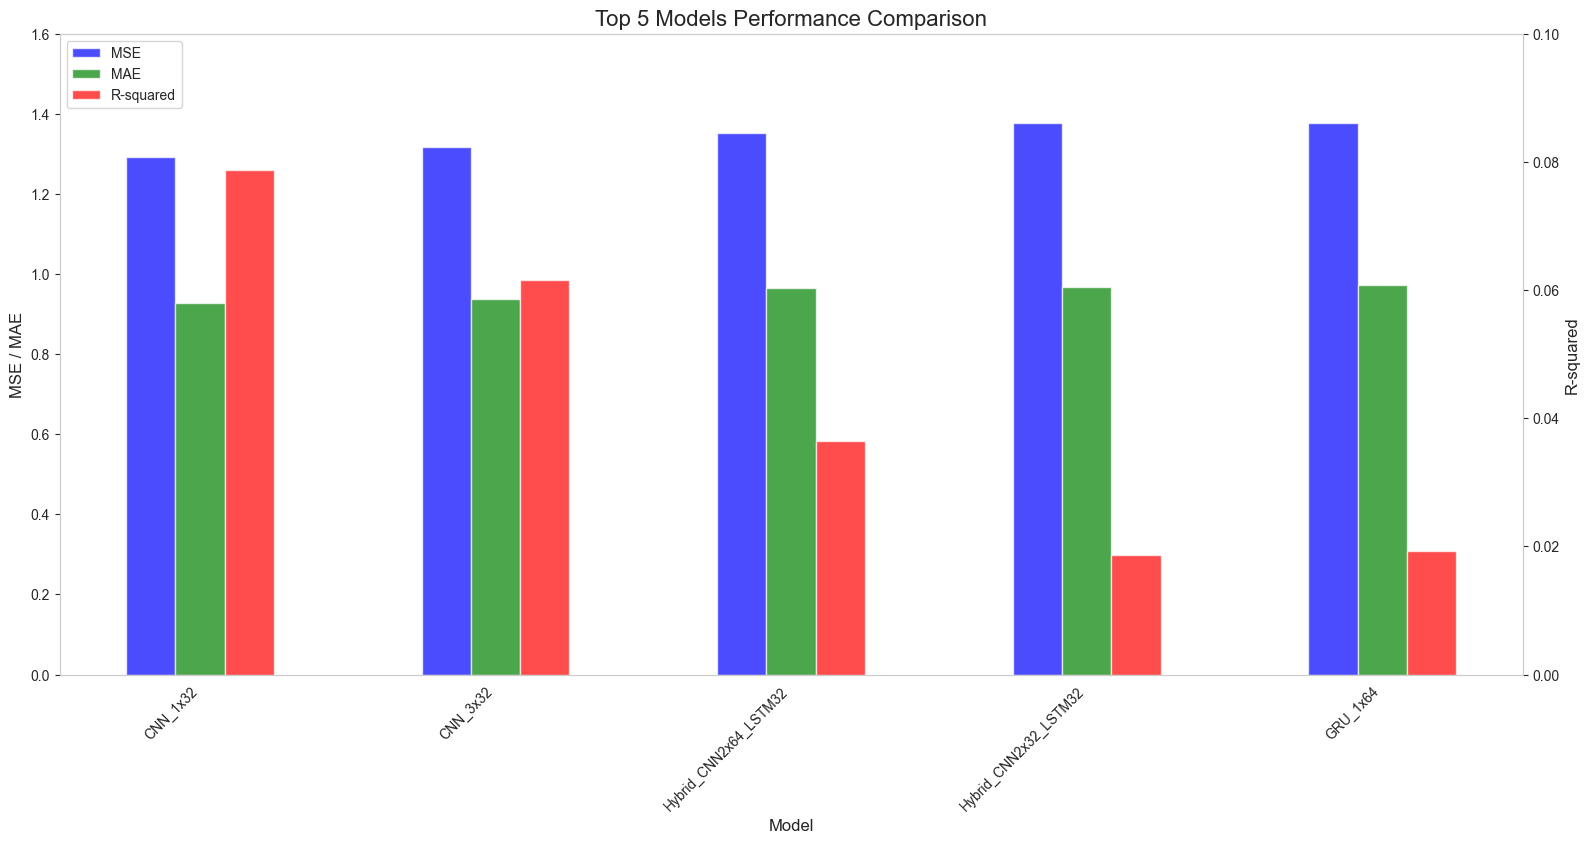

                    Model       MSE  R-squared       MAE     Score
18               CNN_1x32  1.293145   0.078704  0.929025  1.000000
24               CNN_3x32  1.317182   0.061579  0.936790  0.969731
45  Hybrid_CNN2x64_LSTM32  1.352381   0.036501  0.965303  0.905714
43  Hybrid_CNN2x32_LSTM32  1.377374   0.018696  0.969105  0.879148
34               GRU_1x64  1.376602   0.019245  0.971740  0.876806


In [908]:
# Create the plot
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot MSE, MAE, and R-squared
bar_width = 0.25
index = np.arange(len(top_5_models)) * 1.5  # Increase spacing between model groups

ax1.bar(index - bar_width, top_5_models['MSE'], bar_width, label='MSE', color='b', alpha=0.7)
ax1.bar(index, top_5_models['MAE'], bar_width, label='MAE', color='g', alpha=0.7)

ax1.set_xlabel('Model', fontsize=12)
ax1.set_ylabel('MSE / MAE', fontsize=12)
ax1.set_title('Top 5 Models Performance Comparison', fontsize=16)
ax1.set_xticks(index)
ax1.set_xticklabels(top_5_models['Model'], rotation=45, ha='right')
ax1.set_ylim(0, 1.6)
ax1.grid(False)

# Create second y-axis for R-squared
ax2 = ax1.twinx()
ax2.bar(index + bar_width, top_5_models['R-squared'], bar_width, label='R-squared', color='r', alpha=0.7)
ax2.set_ylabel('R-squared', fontsize=12)
ax2.set_ylim(0, 0.1)  # Set R-squared scale from 0 to 0.1
ax2.grid(False)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')



# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Increase bottom margin for model names

plt.show()

# Print the top 5 models and their scores
print(top_5_models[['Model', 'MSE', 'R-squared', 'MAE', 'Score']])

In [910]:
print("X_train range:")
print("Min:", X_train.min())
print("Max:", X_train.max())
print("Percentiles (25th, 50th, 75th):", np.percentile(X_train, [25, 50, 75]))

print("\ny_train range:")
print("Min:", y_train.min())
print("Max:", y_train.max())
print("Percentiles (25th, 50th, 75th):", np.percentile(y_train, [25, 50, 75]))

X_train range:
Min: -2.7657372161895264
Max: 3.665686742657876
Percentiles (25th, 50th, 75th): [-0.84874207  0.04426168  0.79848898]

y_train range:
Min: 0.1906203596086497
Max: 5.633109621361155
Percentiles (25th, 50th, 75th): [1.1442228  1.94161522 2.64333389]


The MSE and MAE values obtained from the models were in the range of 1.293 to 1.377 and 0.929 to 0.972, respectively. Compared to the range of the target variable (0.1906 to 5.6331), these error values were relatively small, indicating that the models made predictions with reasonably low errors. However, the R-squared values of the models remained quite low, with the highest being around 0.079 for the CNN_1x32 model, suggesting that the models captured only a small proportion of the variance in the target variable. This implied that there might be other important factors or complex relationships influencing the burnt area that the models did not fully capture. Given the small range of the target variable and the relatively low error values (MSE and MAE), the models seemed to perform reasonably well in predicting the burnt area of forest fires. Nevertheless, the low R-squared values indicated that there was still considerable room for improvement in terms of capturing more of the underlying factors and relationships that influenced the burnt area.

## Conclusion

The main objective of this project was to create a Deep Learning model capable of predicting the burnt area of forest fires in the Montesinho natural park based on spatial, temporal, and weather variables. The empirical work conducted yielded several key findings. The best performing model was the CNN_1x32 (Convolutional Neural Network with 1 layer and 32 filters), which achieved the lowest Mean Squared Error (MSE) of 1.293, Mean Absolute Error (MAE) of 0.92, and the highest R-squared value of 0.0787 among the tested models. CNN models, particularly CNN_1x32 and CNN_3x32, demonstrated strong performance across all evaluation metrics, suggesting that the CNN architecture is effective in capturing spatial patterns and dependencies in the data. Furthermore, the hybrid models, Hybrid_CNN2x64_LSTM32 and Hybrid_CNN2x32_LSTM32, also showed competitive results, indicating that combining CNN and LSTM architectures can be a promising approach for capturing both spatial and temporal patterns.

The success of the CNN models can be attributed to several factors. CNNs are well-suited for capturing local and spatial patterns in the input data through convolutional filters and pooling operations. The ability to adjust the number of convolutional layers and filters allowed the models to learn complex and hierarchical spatial patterns. Moreover, the spatial dependencies and features learned by the CNN models were crucial for predicting the burnt area of forest fires. However, it is important to note that despite the relatively low error values (MSE and MAE), the R-squared values of the models remained quite low, with the highest being around 0.079 for the CNN_1x32 model. This suggests that there might be other important factors or complex relationships influencing the burnt area that the models did not fully capture. There were also some limitations and challenges encountered during the project, such as the need for careful preprocessing of spatial and temporal data and the limited interpretability of deep learning models compared to traditional statistical models.

## Recommendations

Based on the empirical results, it is recommended to use the CNN_1x32 model as the most suitable choice for predicting the burnt area of forest fires in the Montesinho natural park. To potentially improve its performance, further fine-tuning and optimisation of the CNN_1x32 model should be explored by investigating different hyperparameter settings, such as the number of layers, filters, and regularization techniques.

To gain insights into the spatial patterns and features that contribute to the model's predictions, it is suggested to investigate the interpretability of the CNN model by using techniques like visualisation of learned filters or attention mechanisms. Additionally, incorporating additional data sources, such as satellite imagery or high-resolution spatial data, could enhance the model's ability to capture fine-grained spatial patterns and improve prediction accuracy.

Furthermore, given the low R-squared values of the models, it is recommended to explore additional factors or complex relationships that may influence the burnt area of forest fires. This could involve feature engineering, incorporating domain knowledge, or considering non-linear relationships between variables. By capturing more of the underlying factors and relationships, the predictive performance of the models could be improved.
The implementation of these recommendations is justified by the empirical findings and the specific requirements of the project. By leveraging the strengths of the CNN architecture, incorporating additional data sources, and exploring additional factors influencing the burnt area, the predictive capabilities of the model can be enhanced, ultimately benefiting forest fire prediction and management efforts.

## References

A. Montesinho. (2024, July 4). Montesinho Natural Park. Retrieved from Amontesinho: https://amontesinho.pt/en/the-region/montesinho-natural-park/

Brownlee, J. (2024, July 7). Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras. Retrieved from machinelearningmastery: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

Kanwal, R., Rafaqat, W., Iqbal, M., & Weiguo, S. (2024, July 7). Data-Driven Approaches for Wildfire Mapping and Prediction Assessment Using a Convolutional Neural Network (CNN). Retrieved from mdpi: https://www.mdpi.com/2072-4292/15/21/5099

Keras. (2024, July 7). Title Page. Retrieved from Keras.io: https://keras.io/
Lihore, U. K., Dalal, S., Neetu, F., & Margala, M. (2024, July 7). Hybrid CNN-LSTM model with efficient hyperparameter tuning for prediction of Parkinson’s disease. Retrieved from Nature.com: https://www.nature.com/articles/s41598-023-41314-y

Mishra, S. (2024, July 6). Forest Fire Area. Retrieved from Kaggle: https://www.kaggle.com/datasets/sumitm004/forest-fire-area

Nguyen, Q., & Chakraborty, G. (2016). Predicting forest fire occurrence and incremental fire rate using SAS. Stillwater: Oklahoma State University.

Nosouhian, S., Nosouhian, F., & Khoshouei, A. K. (2024, July 7). A Review of Recurrent Neural Network Architecture for Sequence Learning: Comparison between LSTM and GRU. Retrieved from ResearchGate: https://www.researchgate.net/publication/353214051_A_Review_of_Recurrent_Neural_Network_Architecture_for_Sequence_Learning_Comparison_between_LSTM_and_GRU

UNEP-WCMC and IUCN. (2024, July 4). Protected Planet: The World Database on Protected Areas (WDPA) and World Database on Other Effective Area-based Conservation Measures (WD-OECM). Retrieved from Protected Planet: www.protectedplanet.net

Zhou, Q., & Tang, J. (2024, July 7). An Interpretable Parallel Spatial CNN-LSTM Architecture for Fault Diagnosis in Rotating Machinery. Retrieved from IEEE Xplore: https://ieeexplore.ieee.org/document/10584499

Zhou, X. (2024, July 7). Feedforward Neural Network . Retrieved from ScienceDirect: https://www.sciencedirect.com/topics/computer-science/feedforward-neural-network

